In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import pickle
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
ResNet50_MODEL=tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False,
                                               weights="imagenet")

In [4]:
len(ResNet50_MODEL.layers)

175

In [5]:
ResNet50_MODEL.layers[15].name

'conv2_block1_0_bn'

In [6]:
for layer in ResNet50_MODEL.layers:
    layer.trainable=True

In [7]:
ResNet50_MODEL.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
batch_size = 32
l1_factor = 0.0001
l2_factor = 0.001
dropout = 0.5
learning_rate = 0.0001
target_size_image_shape = (224, 224)

In [9]:
model=tf.keras.models.Sequential([
                                  ResNet50_MODEL,
                                  tf.keras.layers.GlobalAveragePooling2D(),
                                  tf.keras.layers.Dropout(dropout, name='Dropout_Regularization1'),
                                  tf.keras.layers.Dense(31931, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
Dropout_Regularization1 (Dro (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 31931)             65426619  
Total params: 89,014,331
Trainable params: 88,961,211
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
train_data_dir = '../datasets/group1_set_224/set_224/train/'
valid_data_dir = '../datasets/group1_set_224/set_224/valid/'

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [12]:
#flow training images
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 149849 images belonging to 31931 classes.


In [13]:
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 95793 images belonging to 31931 classes.


### Save Labels in  Json file

In [14]:
indices_to_class_labels_dict = {value : key for key, value in train_generator.class_indices.items()}
print(len(indices_to_class_labels_dict))
print(indices_to_class_labels_dict)
with open("group1_indices_to_class_labels_dict.json", "wb") as pickle_file:
    pickle.dump(indices_to_class_labels_dict, pickle_file)

31931
{0: '1000', 1: '100001', 2: '100003', 3: '100008', 4: '100016', 5: '100019', 6: '100020', 7: '100021', 8: '100023', 9: '100026', 10: '10003', 11: '100032', 12: '100035', 13: '100038', 14: '100047', 15: '100053', 16: '100055', 17: '100056', 18: '100064', 19: '100065', 20: '100069', 21: '100090', 22: '100095', 23: '100096', 24: '100103', 25: '100104', 26: '100106', 27: '10011', 28: '100112', 29: '100120', 30: '100128', 31: '100129', 32: '100144', 33: '100158', 34: '100163', 35: '100179', 36: '100184', 37: '1002', 38: '100208', 39: '10021', 40: '100210', 41: '100219', 42: '100223', 43: '100235', 44: '100236', 45: '100237', 46: '100253', 47: '100254', 48: '100256', 49: '100260', 50: '100261', 51: '100262', 52: '100267', 53: '100268', 54: '100271', 55: '100275', 56: '100279', 57: '100294', 58: '10030', 59: '100301', 60: '100321', 61: '100331', 62: '100332', 63: '100347', 64: '100348', 65: '100350', 66: '100355', 67: '100356', 68: '100357', 69: '100362', 70: '100374', 71: '100390', 72:

### Callbacks and Fitting Modeling

In [15]:
outputFolder = 'checkpoints_group1'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
checkpoint_filepath=outputFolder+"/model-{epoch:02d}-{val_acc:.2f}.hdf5"

In [16]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_acc', verbose=1, mode='max',
    save_best_only=True, save_weights_only=True,
    save_frequency='epoch')

In [ ]:
# history = model.fit_generator(
#     generator = train_generator,
#     steps_per_epoch = train_generator.n // batch_size,
#     validation_data = valid_generator,
#     validation_steps = valid_generator.n // batch_size,
#     callbacks=[checkpoint_callback],
#     epochs = 100,
#     workers = 8,
#     verbose=1
# )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
4682/4682 [==============================] - ETA: 0s - loss: 10.3826 - acc: 2.6698e-05
Epoch 00001: val_acc improved from -inf to 0.00008, saving model to checkpoints_group1/model-01-0.00.hdf5
4682/4682 [==============================] - 947s 202ms/step - loss: 10.3826 - acc: 2.6698e-05 - val_loss: 10.3293 - val_acc: 8.3528e-05
Epoch 2/100
4682/4682 [==============================] - ETA: 0s - loss: 10.0933 - acc: 4.0049e-04
Epoch 00002: val_acc improved from 0.00008 to 0.00167, saving model to checkpoints_group1/model-02-0.00.hdf5
4682/4682 [==============================] - 950s 203ms/step - loss: 10.0933 - acc: 4.0049e-04 - val_loss: 9.7616 - val_acc: 0.0017
Epoch 3/100
4682/4682 [==============================] - ETA: 0s - loss: 8.7993 - acc: 0.0106
Epoch 00003: val_acc improved from 0.00167 to 0.01975, saving model to checkpoints_group1/model-03-0.02.hdf5
4682/4682 [============================

In [17]:
model.load_weights("checkpoints_group1/model-28-0.30.hdf5")

In [18]:
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // batch_size,
    callbacks=[checkpoint_callback],
    epochs = 72,
    workers = 4,
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/72
4682/4682 [==============================] - ETA: 0s - loss: 0.3422 - acc: 0.9058
Epoch 00001: val_acc improved from -inf to 0.29255, saving model to checkpoints_group1/model-01-0.29.hdf5
4682/4682 [==============================] - 940s 201ms/step - loss: 0.3422 - acc: 0.9058 - val_loss: 10.1495 - val_acc: 0.2925
Epoch 2/72
4682/4682 [==============================] - ETA: 0s - loss: 0.2877 - acc: 0.9206
Epoch 00002: val_acc improved from 0.29255 to 0.29281, saving model to checkpoints_group1/model-02-0.29.hdf5
4682/4682 [==============================] - 947s 202ms/step - loss: 0.2877 - acc: 0.9206 - val_loss: 10.2519 - val_acc: 0.2928
Epoch 3/72
4682/4682 [==============================] - ETA: 0s - loss: 0.2663 - acc: 0.9268
Epoch 00003: val_acc did not improve from 0.29281
4682/4682 [==============================] - 941s 201ms/step - loss: 0.2663 - acc: 0.9268 - val_loss: 11.2850 - val_acc: 0.2

4682/4682 [==============================] - ETA: 0s - loss: 0.0904 - acc: 0.9740
Epoch 00028: val_acc improved from 0.31391 to 0.31488, saving model to checkpoints_group1/model-28-0.31.hdf5
4682/4682 [==============================] - 946s 202ms/step - loss: 0.0904 - acc: 0.9740 - val_loss: 11.4522 - val_acc: 0.3149
Epoch 29/72
4682/4682 [==============================] - ETA: 0s - loss: 0.0899 - acc: 0.9744
Epoch 00029: val_acc did not improve from 0.31488
4682/4682 [==============================] - 946s 202ms/step - loss: 0.0899 - acc: 0.9744 - val_loss: 11.7476 - val_acc: 0.2981
Epoch 30/72
4682/4682 [==============================] - ETA: 0s - loss: 0.0879 - acc: 0.9752
Epoch 00030: val_acc did not improve from 0.31488
4682/4682 [==============================] - 947s 202ms/step - loss: 0.0879 - acc: 0.9752 - val_loss: 12.2749 - val_acc: 0.2946
Epoch 31/72
4682/4682 [==============================] - ETA: 0s - loss: 0.0843 - acc: 0.9760
Epoch 00031: val_acc did not improve from 0

Epoch 57/72
4682/4682 [==============================] - ETA: 0s - loss: 0.0456 - acc: 0.9870
Epoch 00057: val_acc did not improve from 0.33286
4682/4682 [==============================] - 941s 201ms/step - loss: 0.0456 - acc: 0.9870 - val_loss: 11.9892 - val_acc: 0.3260
Epoch 58/72
4682/4682 [==============================] - ETA: 0s - loss: 0.0475 - acc: 0.9861
Epoch 00058: val_acc did not improve from 0.33286
4682/4682 [==============================] - 941s 201ms/step - loss: 0.0475 - acc: 0.9861 - val_loss: 11.6604 - val_acc: 0.3248
Epoch 59/72
4682/4682 [==============================] - ETA: 0s - loss: 0.0445 - acc: 0.9870
Epoch 00059: val_acc did not improve from 0.33286
4682/4682 [==============================] - 941s 201ms/step - loss: 0.0445 - acc: 0.9870 - val_loss: 11.4540 - val_acc: 0.3291
Epoch 60/72
4682/4682 [==============================] - ETA: 0s - loss: 0.0443 - acc: 0.9870
Epoch 00060: val_acc did not improve from 0.33286
4682/4682 [=============================

<Figure size 432x288 with 0 Axes>

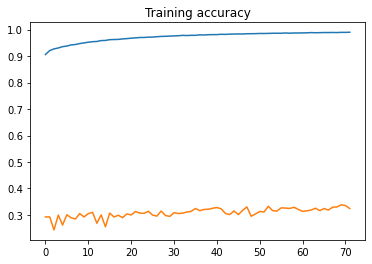

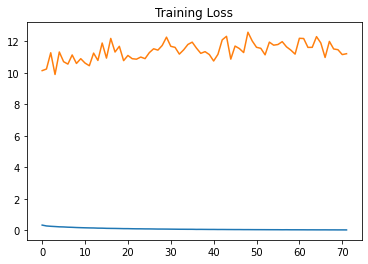

<Figure size 432x288 with 0 Axes>

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training Loss')
plt.figure()

In [ ]:
gsedrfgdffg